## Stock Performance Tracker


## Setup

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import utils, read_utils, draw_utils

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

# plt.style.use("fivethirtyeight")

acc_dict = {
    "acc1": ["ta"],
    "acc2": ["tl"],
}
acc_name_l = list(acc_dict.keys())
acc_combined = "acc_combined"
acc_name_combined_l = acc_name_l + [acc_combined]

index_combined = "index_combined"
index_name_l = ["vni", "vn30"]
index_name_combined_l = index_name_l + [index_combined]


## Read data


### Log table


In [3]:
log_df = read_utils.read_log()
log_df.tail()


,acc1,acc2,vni,vn30
date,,,,
2022-04-04,177632846,535263817,1524.70,1548.04
2022-04-05,178233258,537151885,1520.03,1539.20
2022-04-06,179215543,538461472,1522.90,1557.11
2022-04-07,177532782,533923966,1502.35,1541.96
2022-04-08,177320024,536358112,1482.00,1524.31


### Cashflow


In [5]:
cf_df = read_utils.read_cashflow(acc_dict, acc_combined)
# Drop specific users' columns
cf_df = cf_df[acc_name_combined_l]
cf_df.tail()


,acc1,acc2,acc_combined
date,,,
2022-03-16,80000.0,300000.0,380000.0
2022-03-21,0.0,200000.0,200000.0
2022-03-28,5561413.0,0.0,5561413.0
2022-03-29,0.0,-60000000.0,-60000000.0
2022-04-08,796662.0,0.0,796662.0


## [Chart] Index over time


/Users/kaestrl/projects/python/stock_tracker/draw_utils.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.plot_date(


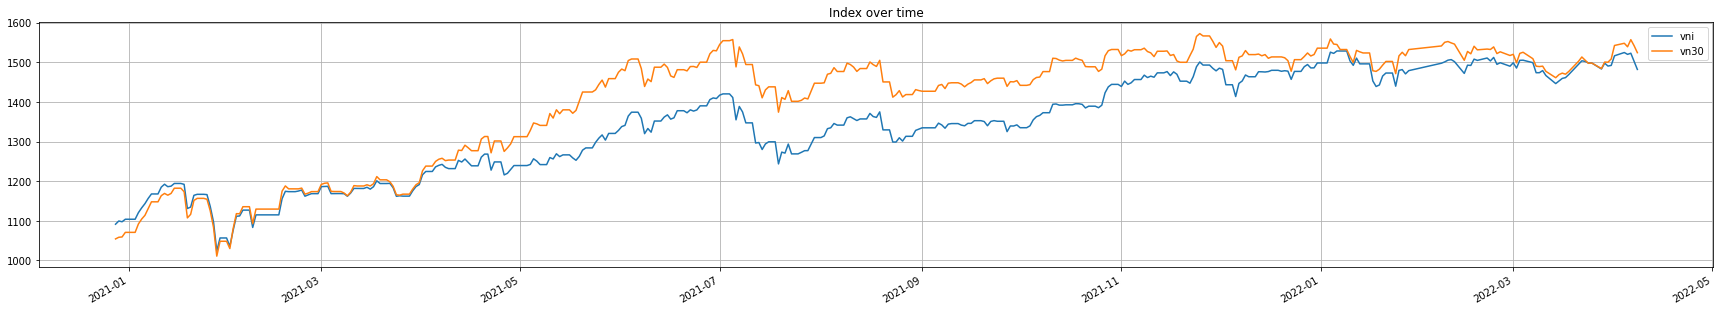

In [12]:
index_values_dict = {
    index_name: list(log_df[index_name]) for index_name in index_name_l
}
draw_utils.plot_indices_over_time(
    time_series=list(log_df.index),
    index_values_dict=index_values_dict,
)


## [Process] Processing


### Adding diff columns


In [7]:
for name in acc_name_l + index_name_l:
    log_df[f"{name}_diff"] = log_df[name].diff()
log_df.tail()


,acc1,acc2,vni,vn30,acc1_diff,acc2_diff,vni_diff,vn30_diff
date,,,,,,,,
2022-04-04,177632846,535263817,1524.70,1548.04,876414.0,1834128.0,8.26,5.57
2022-04-05,178233258,537151885,1520.03,1539.20,600412.0,1888068.0,-4.67,-8.84
2022-04-06,179215543,538461472,1522.90,1557.11,982285.0,1309587.0,2.87,17.91
2022-04-07,177532782,533923966,1502.35,1541.96,-1682761.0,-4537506.0,-20.55,-15.15
2022-04-08,177320024,536358112,1482.00,1524.31,-212758.0,2434146.0,-20.35,-17.65


### Remove unchanged dates from `log_df`


In [8]:
unchanged_filt = log_df[f"{acc_name_l[0]}_diff"] == 0
log_df = log_df.loc[~unchanged_filt]
log_df.tail()


,acc1,acc2,vni,vn30,acc1_diff,acc2_diff,vni_diff,vn30_diff
date,,,,,,,,
2022-04-04,177632846,535263817,1524.70,1548.04,876414.0,1834128.0,8.26,5.57
2022-04-05,178233258,537151885,1520.03,1539.20,600412.0,1888068.0,-4.67,-8.84
2022-04-06,179215543,538461472,1522.90,1557.11,982285.0,1309587.0,2.87,17.91
2022-04-07,177532782,533923966,1502.35,1541.96,-1682761.0,-4537506.0,-20.55,-15.15
2022-04-08,177320024,536358112,1482.00,1524.31,-212758.0,2434146.0,-20.35,-17.65


### Compensating diff with cashflow


In [9]:
for acc_name in acc_name_l:
    log_df[f"{acc_name}_diff"] = log_df[f"{acc_name}_diff"].add(
        cf_df[acc_name], fill_value=0
    )
log_df.tail()

,acc1,acc2,vni,vn30,acc1_diff,acc2_diff,vni_diff,vn30_diff
date,,,,,,,,
2022-04-04,177632846,535263817,1524.70,1548.04,876414.0,1834128.0,8.26,5.57
2022-04-05,178233258,537151885,1520.03,1539.20,600412.0,1888068.0,-4.67,-8.84
2022-04-06,179215543,538461472,1522.90,1557.11,982285.0,1309587.0,2.87,17.91
2022-04-07,177532782,533923966,1502.35,1541.96,-1682761.0,-4537506.0,-20.55,-15.15
2022-04-08,177320024,536358112,1482.00,1524.31,583904.0,2434146.0,-20.35,-17.65


### Adding Combined columns


In [10]:
# Diff for acc
diff_acc_column_name_l = [f"{acc_name}_diff" for acc_name in acc_name_l]

log_df[acc_combined] = log_df[acc_name_l].sum(axis=1)
log_df[f"{acc_combined}_diff"] = log_df[diff_acc_column_name_l].sum(axis=1)

# Diff for index
diff_index_column_name_l = [f"{index_name}_diff" for index_name in index_name_l]

log_df[index_combined] = log_df[index_name_l].mean(axis=1)
log_df[f"{index_combined}_diff"] = log_df[diff_index_column_name_l].mean(axis=1)

log_df.tail()


,acc1,acc2,vni,vn30,acc1_diff,acc2_diff,vni_diff,vn30_diff,acc_combined,acc_combined_diff,index_combined,index_combined_diff
date,,,,,,,,,,,,
2022-04-04,177632846,535263817,1524.70,1548.04,876414.0,1834128.0,8.26,5.57,712896663,2710542.0,1536.370,6.915
2022-04-05,178233258,537151885,1520.03,1539.20,600412.0,1888068.0,-4.67,-8.84,715385143,2488480.0,1529.615,-6.755
2022-04-06,179215543,538461472,1522.90,1557.11,982285.0,1309587.0,2.87,17.91,717677015,2291872.0,1540.005,10.390
2022-04-07,177532782,533923966,1502.35,1541.96,-1682761.0,-4537506.0,-20.55,-15.15,711456748,-6220267.0,1522.155,-17.850
2022-04-08,177320024,536358112,1482.00,1524.31,583904.0,2434146.0,-20.35,-17.65,713678136,3018050.0,1503.155,-19.000


### Calculating diff percent & aux diff percent


In [11]:
for name in acc_name_combined_l + index_name_combined_l:

    log_df[f"{name}_diff_p"] = log_df[f"{name}_diff"] / log_df[name].shift()

    # Replace inf values with nan in diff_p (otherwise, growth would be infinite)
    log_df[f"{name}_diff_p"] = log_df[f"{name}_diff_p"].replace(
        [np.inf, -np.inf], np.nan
    )

    log_df[f"{name}_aux_diff_p"] = log_df[f"{name}_diff_p"] + 1

log_df.tail()


,acc1,acc2,vni,vn30,acc1_diff,acc2_diff,vni_diff,vn30_diff,acc_combined,acc_combined_diff,index_combined,index_combined_diff,acc1_diff_p,acc1_aux_diff_p,acc2_diff_p,acc2_aux_diff_p,acc_combined_diff_p,acc_combined_aux_diff_p,vni_diff_p,vni_aux_diff_p,vn30_diff_p,vn30_aux_diff_p,index_combined_diff_p,index_combined_aux_diff_p
date,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-04,177632846,535263817,1524.70,1548.04,876414.0,1834128.0,8.26,5.57,712896663,2710542.0,1536.370,6.915,0.004958,1.004958,0.003438,1.003438,0.003817,1.003817,0.005447,1.005447,0.003611,1.003611,0.004521,1.004521
2022-04-05,178233258,537151885,1520.03,1539.20,600412.0,1888068.0,-4.67,-8.84,715385143,2488480.0,1529.615,-6.755,0.003380,1.003380,0.003527,1.003527,0.003491,1.003491,-0.003063,0.996937,-0.005710,0.994290,-0.004397,0.995603
2022-04-06,179215543,538461472,1522.90,1557.11,982285.0,1309587.0,2.87,17.91,717677015,2291872.0,1540.005,10.390,0.005511,1.005511,0.002438,1.002438,0.003204,1.003204,0.001888,1.001888,0.011636,1.011636,0.006793,1.006793
2022-04-07,177532782,533923966,1502.35,1541.96,-1682761.0,-4537506.0,-20.55,-15.15,711456748,-6220267.0,1522.155,-17.850,-0.009390,0.990610,-0.008427,0.991573,-0.008667,0.991333,-0.013494,0.986506,-0.009730,0.990270,-0.011591,0.988409
2022-04-08,177320024,536358112,1482.00,1524.31,583904.0,2434146.0,-20.35,-17.65,713678136,3018050.0,1503.155,-19.000,0.003289,1.003289,0.004559,1.004559,0.004242,1.004242,-0.013545,0.986455,-0.011446,0.988554,-0.012482,0.987518


## [Chart] NAV

/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_46117/1835900296.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(abs(ax1.get_yticks()/1_000_000))


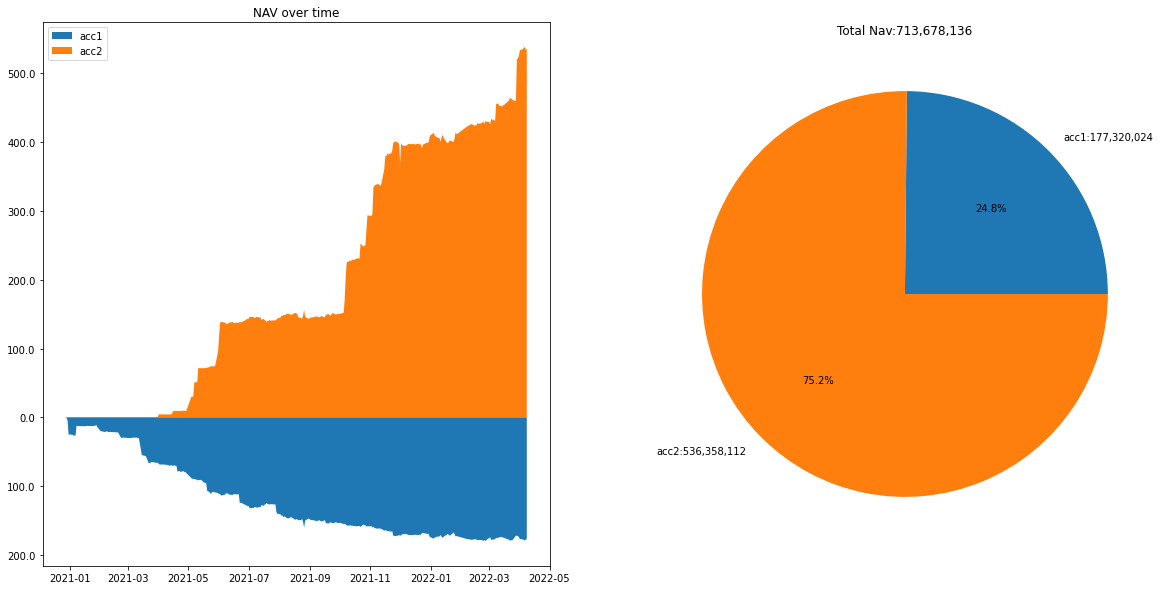

In [12]:
fig, (ax1, ax2) = plt.subplots(figsize=(20, 10), ncols=2)  # type: ignore


# Line plot
for i, acc_name in enumerate(acc_name_l):
    sign = -1 if i % 2 == 0 else 1
    ax1.fill_between(log_df.index, sign * log_df[acc_name], label=acc_name)

# set labels to absolute values
ax1.set_yticklabels(abs(ax1.get_yticks()/1_000_000))

ax1.set_title("NAV over time")
ax1.legend(loc="upper left")

# Pie chart
nav_l = [log_df[acc_name].iloc[-1] for acc_name in acc_name_l]  # type: ignore
label_l = [f"{acc_name}:{nav:,}" for acc_name, nav in zip(acc_name_l, nav_l)]
ax2.pie(nav_l, labels=label_l, autopct="%1.1f%%")

ax2.set_title(f"Total Nav:{np.sum(nav_l):,}")


plt.show()


## [Chart] Profit

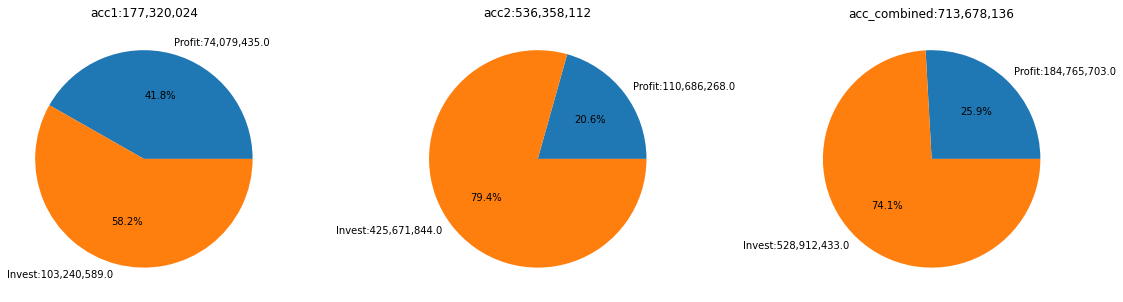

In [14]:
fig, ax_l = plt.subplots(figsize=(20, 5), ncols=3, facecolor="white")  # type: ignore

for name, ax in zip(acc_name_combined_l, ax_l):  # type: ignore
    nav = log_df[name].iloc[-1]
    invest = -cf_df[name].sum()
    profit = nav - invest

    profit_label = f"Profit:{profit:,}"
    invest_label = f"Invest:{invest:,}"

    ax.pie([profit, invest], labels=[profit_label, invest_label], autopct="%1.1f%%")
    ax.set_title(f"{name}:{nav:,}")

plt.show()


## [Chart] Diff percent


### Histogram

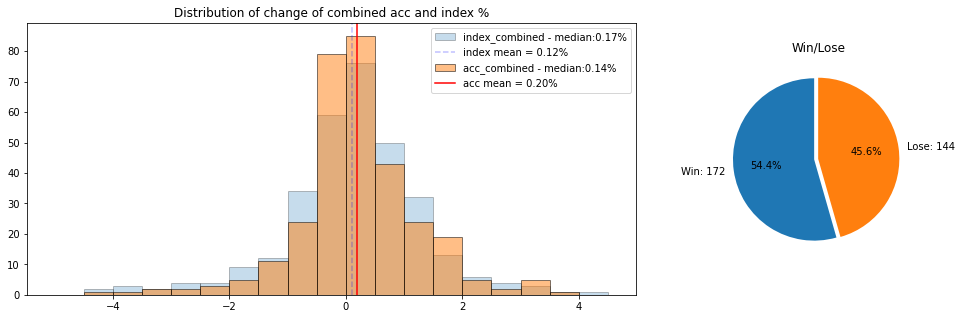

In [15]:
fig, (ax1, ax2) = plt.subplots(
    figsize=(16, 5),
    ncols=2,
    gridspec_kw={"width_ratios": [3, 1]},
)  # type: ignore

index_diff_p_l = log_df[f"{index_combined}_diff_p"] * 100
acc_diff_p_l = log_df[f"{acc_combined}_diff_p"] * 100

# *** Histogram ***

bins = np.arange(-5, 5, 0.5).tolist()

# Index histogram
index_combined_median = index_diff_p_l.median()
ax1.hist(
    index_diff_p_l,
    bins=bins,
    edgecolor="black",
    alpha=0.25,
    label=f"{index_combined} - median:{index_combined_median:.2f}%",
)
index_diff_p_mean = index_diff_p_l.mean()  # type: ignore

ax1.axvline(
    index_diff_p_mean,
    color="blue",
    linestyle="--",
    label="index mean = %.2f%%" % index_diff_p_mean,
    alpha=0.25,
)

# acc histogram
acc_combined_median = acc_diff_p_l.median()
ax1.hist(
    acc_diff_p_l,
    bins=bins,
    edgecolor="black",
    alpha=0.5,
    label=f"{acc_combined} - median:{acc_combined_median:.2f}%",
)
acc_diff_p_mean = acc_diff_p_l.mean()  # type: ignore
ax1.axvline(
    acc_diff_p_mean,
    color="red",
    label="acc mean = %.2f%%" % acc_diff_p_mean,
)


ax1.set_title("Distribution of change of combined acc and index %")
ax1.legend()

# *** Win / Lose pie chart ***
win_num = (acc_diff_p_l > index_diff_p_l).sum()
lose_num = (acc_diff_p_l <= index_diff_p_l).sum()
ax2.pie(
    [win_num, lose_num],
    labels=[f"Win: {win_num}", f"Lose: {lose_num}"],
    autopct="%1.1f%%",
    startangle=90,
    explode=[0.05, 0],
)
ax2.set_title("Win/Lose")

plt.show()


### Scatter plot


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


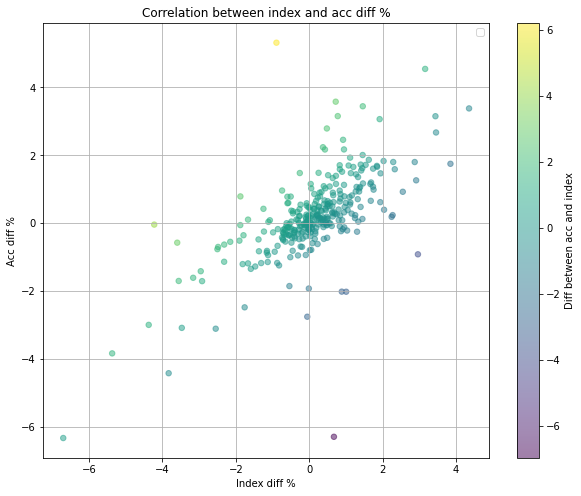

In [16]:
plt.figure(figsize=(10, 8))

index_diff_p_l = log_df[f"{index_combined}_diff_p"] * 100
acc_diff_p_l = log_df[f"{acc_combined}_diff_p"] * 100
plt.scatter(
    index_diff_p_l,
    acc_diff_p_l,
    c=acc_diff_p_l - index_diff_p_l,  # type: ignore
    s=30,
    alpha=0.5,
)

cbar = plt.colorbar()
cbar.set_label("Diff between acc and index")

plt.title("Correlation between index and acc diff %")
plt.xlabel("Index diff %")
plt.ylabel("Acc diff %")

plt.legend()
plt.grid(True)
plt.show()


## [Chart] Daily


In [17]:
# Filter 10 latest days
recent_daily_df = log_df.iloc[-10:]


### Latest growth

/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_46117/2183069652.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_46117/2183069652.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_46117/2183069652.py:46: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_46117/2183069652.py:46: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument wil

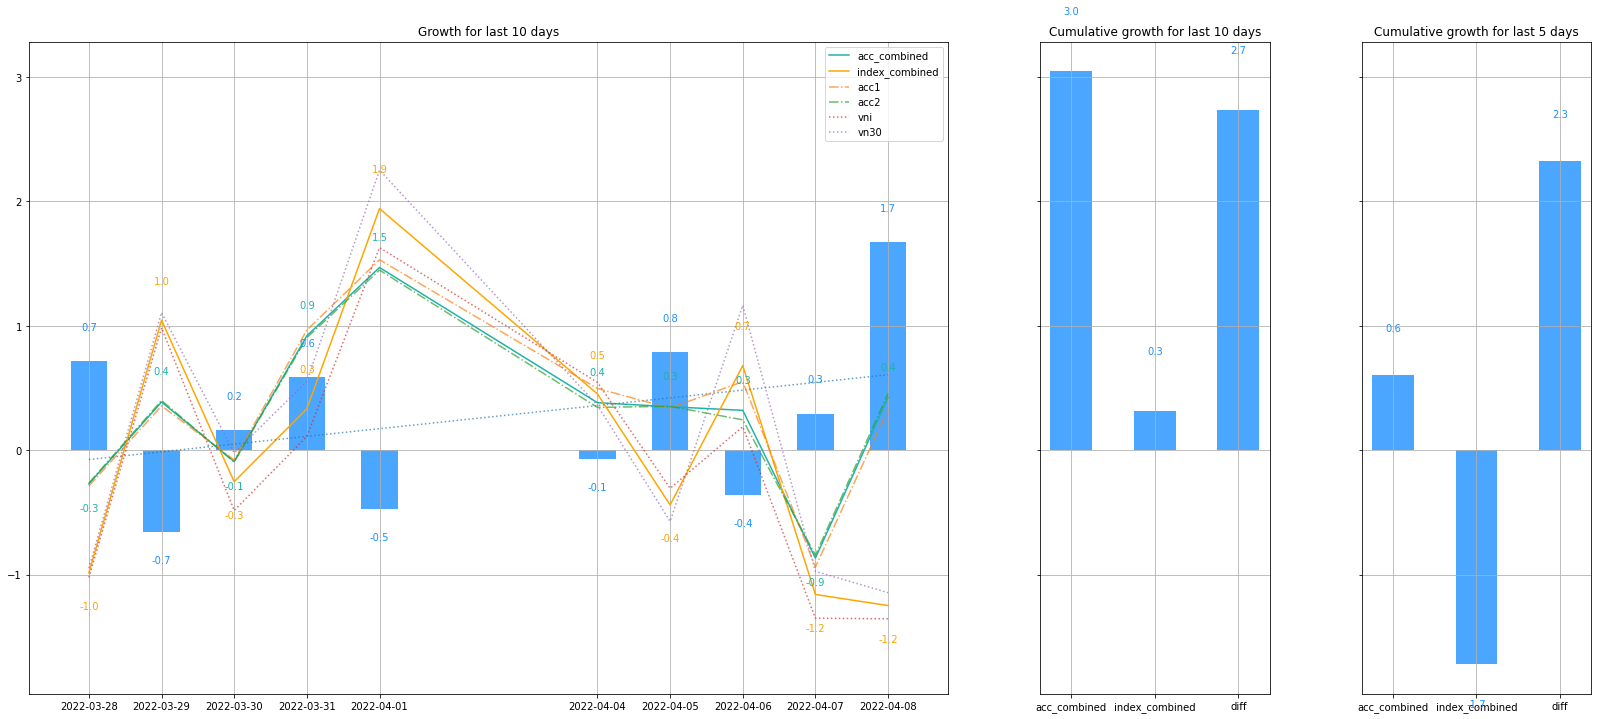

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(
    figsize=(28, 12),
    ncols=3,
    sharey=True,
    gridspec_kw={"width_ratios": [4, 1, 1]},
)  # type: ignore

# * Last x days line plot

for combined_name, color in zip(
    [acc_combined, index_combined], ["lightseagreen", "orange"]
):
    x = recent_daily_df.index
    y = recent_daily_df[f"{combined_name}_diff_p"] * 100
    ax1.plot_date(
        x,
        y,
        linestyle="-",
        marker=None,
        label=combined_name,
        color=color,
    )
    utils.add_labels(ax1, x, y, color=color)

recent_diff_df = (
    recent_daily_df[f"{acc_combined}_diff_p"]
    - recent_daily_df[f"{index_combined}_diff_p"]
) * 100

ax1.bar(
    recent_daily_df.index,
    recent_diff_df,
    width=0.5,
    alpha=0.8,
    color="dodgerblue",
)
utils.add_labels(ax1, recent_daily_df.index, recent_diff_df, color="dodgerblue")

# Trendline
first_date = recent_daily_df.index[0]
x = [(date - first_date).days for date in recent_daily_df.index]
utils.add_trend_line(ax1, ticks=recent_daily_df.index, x=x, y=recent_diff_df)


for single_name in acc_name_l:
    ax1.plot_date(
        recent_daily_df.index,
        recent_daily_df[f"{single_name}_diff_p"] * 100,
        linestyle="-.",
        marker=None,
        alpha=0.7,
        label=single_name,
    )

for single_name in index_name_l:
    ax1.plot_date(
        recent_daily_df.index,
        recent_daily_df[f"{single_name}_diff_p"] * 100,
        linestyle=":",
        marker=None,
        alpha=0.7,
        label=single_name,
    )


ax1.set_title("Growth for last 10 days")
ax1.set_xticks(ticks=recent_daily_df.index)
ax1.legend()
ax1.grid(True)


# * Cumulative growth bar plot
def _plot_cum_growth(df: pd.DataFrame, ax: plt.Axes, day_num: int) -> None:
    cum_acc_growth = (df[f"{acc_combined}_aux_diff_p"].product() - 1) * 100  # type: ignore
    cum_index_growth = (df[f"{index_combined}_aux_diff_p"].product() - 1) * 100  # type: ignore
    cum_diff_growth = cum_acc_growth - cum_index_growth
    x = [acc_combined, index_combined, "diff"]
    y = [cum_acc_growth, cum_index_growth, cum_diff_growth]
    ax.bar(
        x,
        y,
        width=0.5,
        alpha=0.8,
        color="dodgerblue",
    )
    ax.set_title(f"Cumulative growth for last {day_num} days")
    ax.grid(True)
    utils.add_labels(ax, x, y,color="dodgerblue")


_plot_cum_growth(recent_daily_df, ax2, 10)
_plot_cum_growth(recent_daily_df.iloc[-5:], ax3, 5)

plt.show()


In [20]:
recent_daily_df

,acc1,acc2,vni,vn30,acc1_diff,acc2_diff,vni_diff,vn30_diff,acc_combined,acc_combined_diff,index_combined,index_combined_diff,acc1_diff_p,acc1_aux_diff_p,acc2_diff_p,acc2_aux_diff_p,acc_combined_diff_p,acc_combined_aux_diff_p,vni_diff_p,vni_aux_diff_p,vn30_diff_p,vn30_aux_diff_p,index_combined_diff_p,index_combined_aux_diff_p
date,,,,,,,,,,,,,,,,,,,,,,,,
2022-03-28,171953253,459768219,1483.18,1484.16,-511091.0,-1217121.0,-15.32,-14.20,631721472,-1728212.0,1483.670,-14.760,-0.002871,0.997129,-0.002640,0.997360,-0.002705,0.997295,-0.010224,0.989776,-0.009477,0.990523,-0.009850,0.990150
2022-03-29,172564404,521604878,1497.76,1500.57,611151.0,1836659.0,14.58,16.41,694169282,2447810.0,1499.165,15.495,0.003554,1.003554,0.003995,1.003995,0.003875,1.003875,0.009830,1.009830,0.011057,1.011057,0.010444,1.010444
2022-03-30,172429106,521110335,1490.51,1500.23,-135298.0,-494543.0,-7.25,-0.34,693539441,-629841.0,1495.370,-3.795,-0.000784,0.999216,-0.000948,0.999052,-0.000907,0.999093,-0.004841,0.995159,-0.000227,0.999773,-0.002531,0.997469
2022-03-31,174093027,525820563,1492.15,1508.53,1663921.0,4710228.0,1.64,8.30,699913590,6374149.0,1500.340,4.970,0.009650,1.009650,0.009039,1.009039,0.009191,1.009191,0.001100,1.001100,0.005532,1.005532,0.003324,1.003324
2022-04-01,176756432,533429689,1516.44,1542.47,2663405.0,7609126.0,24.29,33.94,710186121,10272531.0,1529.455,29.115,0.015299,1.015299,0.014471,1.014471,0.014677,1.014677,0.016279,1.016279,0.022499,1.022499,0.019406,1.019406
2022-04-04,177632846,535263817,1524.70,1548.04,876414.0,1834128.0,8.26,5.57,712896663,2710542.0,1536.370,6.915,0.004958,1.004958,0.003438,1.003438,0.003817,1.003817,0.005447,1.005447,0.003611,1.003611,0.004521,1.004521
2022-04-05,178233258,537151885,1520.03,1539.20,600412.0,1888068.0,-4.67,-8.84,715385143,2488480.0,1529.615,-6.755,0.003380,1.003380,0.003527,1.003527,0.003491,1.003491,-0.003063,0.996937,-0.005710,0.994290,-0.004397,0.995603
2022-04-06,179215543,538461472,1522.90,1557.11,982285.0,1309587.0,2.87,17.91,717677015,2291872.0,1540.005,10.390,0.005511,1.005511,0.002438,1.002438,0.003204,1.003204,0.001888,1.001888,0.011636,1.011636,0.006793,1.006793
2022-04-07,177532782,533923966,1502.35,1541.96,-1682761.0,-4537506.0,-20.55,-15.15,711456748,-6220267.0,1522.155,-17.850,-0.009390,0.990610,-0.008427,0.991573,-0.008667,0.991333,-0.013494,0.986506,-0.009730,0.990270,-0.011591,0.988409


### XIRR

/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_46117/4119070091.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_46117/4119070091.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_46117/4119070091.py:57: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot_date(
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_46117/4119070091.py:57: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument wil

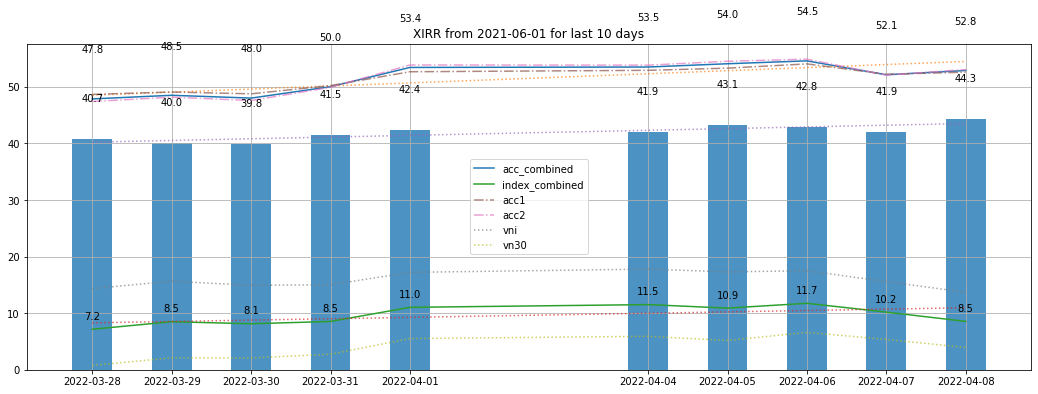

In [21]:
anchor_date = "2021-06-01"

xirr_data = {name: [] for name in acc_name_combined_l + index_name_combined_l}
for idx in recent_daily_df.index:
    for name in acc_name_combined_l:
        xirr_data[name].append(
            utils.calc_cashflow_xirr(
                cf_df,
                log_df,
                anchor_date,
                idx,
                name,
                acc_name_combined_l,
            )
        )
    for idx_name in index_name_combined_l:
        xirr_data[idx_name].append(utils.calc_index_xirr(log_df, anchor_date, idx, idx_name))
xirr_df = pd.DataFrame(xirr_data, index=recent_daily_df.index)


fig, ax1 = plt.subplots(figsize=(18, 6))  # type: ignore

# * Last x days line plot

for combined_name in [acc_combined, index_combined]:
    ax1.plot_date(
        xirr_df.index,
        xirr_df[combined_name] * 100,  # type: ignore
        linestyle="-",
        marker=None,
        label=combined_name,
    )
    utils.add_labels(ax1, xirr_df.index, xirr_df[combined_name] * 100)  # type: ignore

    # Trendline
    first_date = xirr_df.index[0]
    x = [(date - first_date).days for date in xirr_df.index]
    utils.add_trend_line(ax1, ticks=xirr_df.index, x=x, y=xirr_df[combined_name] * 100)  # type: ignore

recent_diff = (xirr_df[acc_combined] - xirr_df[index_combined]) * 100  # type: ignore

ax1.bar(
    xirr_df.index,
    recent_diff,
    width=0.5,
    alpha=0.8,
)
utils.add_labels(ax1, xirr_df.index, recent_diff)  # type: ignore

# Trendline
first_date = xirr_df.index[0]
x = [(date - first_date).days for date in xirr_df.index]
utils.add_trend_line(ax1, ticks=xirr_df.index, x=x, y=recent_diff)  # type: ignore


for single_name in acc_name_l:
    ax1.plot_date(
        xirr_df.index,
        xirr_df[single_name] * 100,  # type: ignore
        linestyle="-.",
        marker=None,
        alpha=0.7,
        label=single_name,
    )

for single_name in index_name_l:
    ax1.plot_date(
        xirr_df.index,
        xirr_df[single_name] * 100,  # type: ignore
        linestyle=":",
        marker=None,
        alpha=0.7,
        label=single_name,
    )


ax1.set_title(f"XIRR from {anchor_date} for last 10 days")
ax1.set_xticks(ticks=xirr_df.index)
ax1.legend()
ax1.grid(True)

plt.show()


In [22]:
xirr_df

,acc1,acc2,acc_combined,vni,vn30,index_combined
date,,,,,,
2022-03-28,0.486270,0.473738,0.478292,0.143355,0.007718,0.071612
2022-03-29,0.490498,0.481387,0.484696,0.156440,0.021174,0.084904
2022-03-30,0.487282,0.475430,0.479727,0.149148,0.020824,0.081306
2022-03-31,0.501877,0.498751,0.499884,0.150141,0.027539,0.085343
2022-04-01,0.526240,0.538205,0.533860,0.172044,0.055173,0.110298
2022-04-04,0.528787,0.537889,0.534597,0.177791,0.059135,0.115112
2022-04-05,0.532613,0.544799,0.540396,0.172910,0.051799,0.108932
2022-04-06,0.540103,0.548459,0.545444,0.174913,0.066050,0.117433
2022-04-07,0.521845,0.520361,0.520895,0.155729,0.053671,0.101854


### Income

/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_46117/2291495792.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_46117/2291495792.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_46117/2291495792.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(


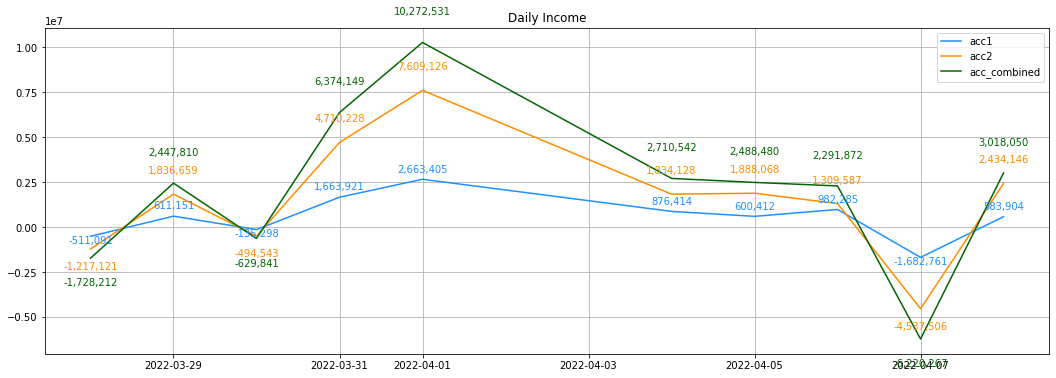

In [23]:
fig, ax = plt.subplots(figsize=(18, 6))  # type: ignore

for name, color in zip(acc_name_combined_l, ["dodgerblue", "darkorange", "darkgreen"]):
    income_l = recent_daily_df[f"{name}_diff"]
    ax.plot_date(
        recent_daily_df.index,
        income_l,  # type: ignore
        linestyle="-",
        marker=None,
        label=name,
        color=color,
    )

    label_l = [f"{income:,.0f}" for income in income_l]
    utils.add_labels(ax, recent_daily_df.index, income_l,label_l=label_l, color=color)  # type: ignore

ax.set_title("Daily Income")
ax.grid(True)
ax.legend()

plt.show()


In [24]:
recent_daily_df

,acc1,acc2,vni,vn30,acc1_diff,acc2_diff,vni_diff,vn30_diff,acc_combined,acc_combined_diff,index_combined,index_combined_diff,acc1_diff_p,acc1_aux_diff_p,acc2_diff_p,acc2_aux_diff_p,acc_combined_diff_p,acc_combined_aux_diff_p,vni_diff_p,vni_aux_diff_p,vn30_diff_p,vn30_aux_diff_p,index_combined_diff_p,index_combined_aux_diff_p
date,,,,,,,,,,,,,,,,,,,,,,,,
2022-03-28,171953253,459768219,1483.18,1484.16,-511091.0,-1217121.0,-15.32,-14.20,631721472,-1728212.0,1483.670,-14.760,-0.002871,0.997129,-0.002640,0.997360,-0.002705,0.997295,-0.010224,0.989776,-0.009477,0.990523,-0.009850,0.990150
2022-03-29,172564404,521604878,1497.76,1500.57,611151.0,1836659.0,14.58,16.41,694169282,2447810.0,1499.165,15.495,0.003554,1.003554,0.003995,1.003995,0.003875,1.003875,0.009830,1.009830,0.011057,1.011057,0.010444,1.010444
2022-03-30,172429106,521110335,1490.51,1500.23,-135298.0,-494543.0,-7.25,-0.34,693539441,-629841.0,1495.370,-3.795,-0.000784,0.999216,-0.000948,0.999052,-0.000907,0.999093,-0.004841,0.995159,-0.000227,0.999773,-0.002531,0.997469
2022-03-31,174093027,525820563,1492.15,1508.53,1663921.0,4710228.0,1.64,8.30,699913590,6374149.0,1500.340,4.970,0.009650,1.009650,0.009039,1.009039,0.009191,1.009191,0.001100,1.001100,0.005532,1.005532,0.003324,1.003324
2022-04-01,176756432,533429689,1516.44,1542.47,2663405.0,7609126.0,24.29,33.94,710186121,10272531.0,1529.455,29.115,0.015299,1.015299,0.014471,1.014471,0.014677,1.014677,0.016279,1.016279,0.022499,1.022499,0.019406,1.019406
2022-04-04,177632846,535263817,1524.70,1548.04,876414.0,1834128.0,8.26,5.57,712896663,2710542.0,1536.370,6.915,0.004958,1.004958,0.003438,1.003438,0.003817,1.003817,0.005447,1.005447,0.003611,1.003611,0.004521,1.004521
2022-04-05,178233258,537151885,1520.03,1539.20,600412.0,1888068.0,-4.67,-8.84,715385143,2488480.0,1529.615,-6.755,0.003380,1.003380,0.003527,1.003527,0.003491,1.003491,-0.003063,0.996937,-0.005710,0.994290,-0.004397,0.995603
2022-04-06,179215543,538461472,1522.90,1557.11,982285.0,1309587.0,2.87,17.91,717677015,2291872.0,1540.005,10.390,0.005511,1.005511,0.002438,1.002438,0.003204,1.003204,0.001888,1.001888,0.011636,1.011636,0.006793,1.006793
2022-04-07,177532782,533923966,1502.35,1541.96,-1682761.0,-4537506.0,-20.55,-15.15,711456748,-6220267.0,1522.155,-17.850,-0.009390,0.990610,-0.008427,0.991573,-0.008667,0.991333,-0.013494,0.986506,-0.009730,0.990270,-0.011591,0.988409


### Growth time series


In [25]:
def get_overall_growth_xirr_df(
    log_df: pd.DataFrame,
    anchor_date: str = "2020-12-29",
) -> pd.DataFrame:
    filtered_log_df:pd.DataFrame = log_df[log_df.index >= anchor_date]  # type: ignore
    df = pd.DataFrame(index=filtered_log_df.index)
    for name in acc_name_combined_l + index_name_combined_l:
        # set first date aux_diff_p to 1
        filtered_log_df[f"{name}_aux_diff_p"].iloc[0] = 1  # type: ignore
        # calculate growth using cumulative product since anchor date
        
        df[f"{name}_growth"] = filtered_log_df[f"{name}_aux_diff_p"].cumprod() * 100

    df = df.fillna(100)
        
    for name in acc_name_combined_l:
        df[f"{name}_xirr"] = filtered_log_df.index.to_series().apply(
            lambda date_idx: utils.calc_cashflow_xirr(
                cf_df,
                log_df,
                anchor_date,
                date_idx,
                name,
                acc_name_combined_l,
            )
        ) * 100
        # The first few xirr are too crazy to be included
        df.iloc[:5, df.columns.get_loc(f"{name}_xirr")] = 0
        
    for name in index_name_combined_l:
        df[f"{name}_xirr"] = filtered_log_df.index.to_series().apply(
            lambda date_idx: utils.calc_index_xirr(
                log_df,
                anchor_date,
                date_idx,
                name,
            )
        ) * 100
        # The first few xirr are too crazy to be included
        df.iloc[:5, df.columns.get_loc(f"{name}_xirr")] = 0
    
    return df


/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_46117/1795310595.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_log_df[f"{name}_aux_diff_p"].iloc[0] = 1  # type: ignore
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_46117/1795310595.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_log_df[f"{name}_aux_diff_p"].iloc[0] = 1  # type: ignore
/var/folders/2s/x1r3gsqj0y14ztflmlggyqzm0000gn/T/ipykernel_46117/1795310595.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

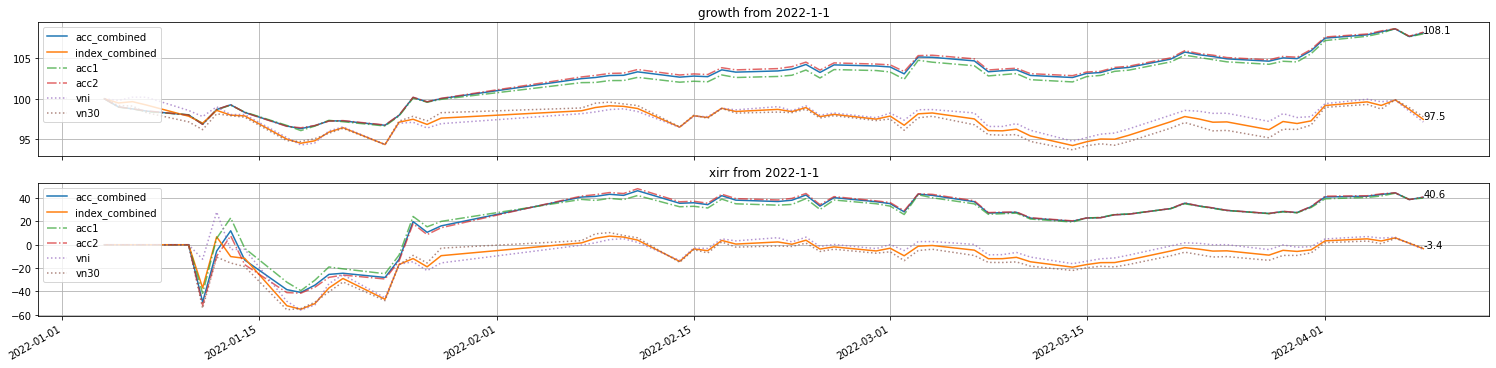

In [26]:
fig, (ax1, ax2) = plt.subplots(figsize=(26, 6), nrows=2)  # type: ignore

anchor_date = "2022-1-1"
growth_xirr_df = get_overall_growth_xirr_df(log_df, anchor_date=anchor_date)


def _plot_overall_growth_xirr(ax: plt.Axes, type: str):

    for combined_name in [acc_combined, index_combined]:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{combined_name}_{type}"],
            linestyle="-",
            marker=None,
            label=combined_name,
        )
        ax.text(
            growth_xirr_df.index[-1],
            growth_xirr_df[f"{combined_name}_{type}"].iloc[-1],  # type: ignore
            f"{growth_xirr_df[f'{combined_name}_{type}'].iloc[-1]:.1f}",  # type: ignore
        )

    for single_name in acc_name_l:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{single_name}_{type}"],
            linestyle="-.",
            marker=None,
            alpha=0.7,
            label=single_name,
        )

    for single_name in index_name_l:
        ax.plot_date(
            growth_xirr_df.index,
            growth_xirr_df[f"{single_name}_{type}"],
            linestyle=":",
            marker=None,
            alpha=0.7,
            label=single_name,
        )

    ax.set_title(f"{type} from {anchor_date}")
    ax.legend(loc="upper left")
    ax.grid(True)
    fig.autofmt_xdate()
    
_plot_overall_growth_xirr(ax1, "growth")
_plot_overall_growth_xirr(ax2, "xirr")

plt.show()


In [27]:
growth_xirr_df

,acc1_growth,acc2_growth,acc_combined_growth,vni_growth,vn30_growth,index_combined_growth,acc1_xirr,acc2_xirr,acc_combined_xirr,vni_xirr,vn30_xirr,index_combined_xirr
date,,,,,,,,,,,,
2022-01-04,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-05,98.970350,99.011039,98.998864,99.798110,99.175043,99.483214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-06,98.762565,98.759720,98.760572,100.195991,99.107045,99.645642,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-07,98.424627,98.512278,98.486049,100.190092,98.291711,99.230657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-10,98.035044,98.006812,98.015260,98.566447,97.166537,97.858938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022-01-11,96.900635,96.854735,96.868470,97.819190,96.206868,97.004328,-41.611922,-51.951093,-49.070692,-12.407898,-54.453851,-36.990503
2022-01-12,98.657703,98.685986,98.677523,99.012179,98.150583,98.576732,5.482469,-9.710333,-5.417844,28.053003,-10.641097,6.790094
2022-01-13,99.212779,99.275810,99.256949,98.064343,97.919005,97.990890,22.973006,7.575246,11.959447,-4.095768,-15.648546,-10.122049
2022-01-14,98.368970,98.309286,98.327146,98.062376,97.735539,97.897194,-3.019793,-17.077507,-13.105999,-3.859136,-18.691302,-11.665148


## [Process] Add period info


In [28]:
log_df["Y"] = log_df.index.to_period("Y")  # type: ignore
log_df["Q"] = log_df.index.to_period("Q")  # type: ignore
log_df["M"] = log_df.index.to_period("M")  # type: ignore
log_df["W"] = log_df.index.to_period("W")  # type: ignore
log_df.tail()


,acc1,acc2,vni,vn30,acc1_diff,acc2_diff,vni_diff,vn30_diff,acc_combined,acc_combined_diff,index_combined,index_combined_diff,acc1_diff_p,acc1_aux_diff_p,acc2_diff_p,acc2_aux_diff_p,acc_combined_diff_p,acc_combined_aux_diff_p,vni_diff_p,vni_aux_diff_p,vn30_diff_p,vn30_aux_diff_p,index_combined_diff_p,index_combined_aux_diff_p,Y,Q,M,W
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-04,177632846,535263817,1524.70,1548.04,876414.0,1834128.0,8.26,5.57,712896663,2710542.0,1536.370,6.915,0.004958,1.004958,0.003438,1.003438,0.003817,1.003817,0.005447,1.005447,0.003611,1.003611,0.004521,1.004521,2022,2022Q2,2022-04,2022-04-04/2022-04-10
2022-04-05,178233258,537151885,1520.03,1539.20,600412.0,1888068.0,-4.67,-8.84,715385143,2488480.0,1529.615,-6.755,0.003380,1.003380,0.003527,1.003527,0.003491,1.003491,-0.003063,0.996937,-0.005710,0.994290,-0.004397,0.995603,2022,2022Q2,2022-04,2022-04-04/2022-04-10
2022-04-06,179215543,538461472,1522.90,1557.11,982285.0,1309587.0,2.87,17.91,717677015,2291872.0,1540.005,10.390,0.005511,1.005511,0.002438,1.002438,0.003204,1.003204,0.001888,1.001888,0.011636,1.011636,0.006793,1.006793,2022,2022Q2,2022-04,2022-04-04/2022-04-10
2022-04-07,177532782,533923966,1502.35,1541.96,-1682761.0,-4537506.0,-20.55,-15.15,711456748,-6220267.0,1522.155,-17.850,-0.009390,0.990610,-0.008427,0.991573,-0.008667,0.991333,-0.013494,0.986506,-0.009730,0.990270,-0.011591,0.988409,2022,2022Q2,2022-04,2022-04-04/2022-04-10
2022-04-08,177320024,536358112,1482.00,1524.31,583904.0,2434146.0,-20.35,-17.65,713678136,3018050.0,1503.155,-19.000,0.003289,1.003289,0.004559,1.004559,0.004242,1.004242,-0.013545,0.986455,-0.011446,0.988554,-0.012482,0.987518,2022,2022Q2,2022-04,2022-04-04/2022-04-10


In [34]:
def get_period_df(period_symbol, log_df):
    period_l = log_df[period_symbol].unique()

    data = []
    for period in period_l:
        period_data_dict = {"period": period}
        period_filt = log_df[period_symbol] == period
        period_df = log_df.loc[period_filt]

        for name in acc_name_combined_l + index_name_combined_l:
            period_growth = period_df[f"{name}_aux_diff_p"].product()  # type: ignore
            period_data_dict[f"{name}_growth"] = (period_growth - 1) * 100  # type: ignore

        for acc_name in acc_name_combined_l:
            period_xirr = utils.calc_cashflow_xirr(
                cf_df,
                log_df,
                anchor_date=period_df.index[0],
                date_idx=period_df.index[-1],
                col_name=acc_name,
                user_name_combined_l=acc_name_combined_l,
            )  # type: ignore
            period_data_dict[f"{acc_name}_xirr"] = period_xirr * 100  # type: ignore

            period_data_dict[f"{acc_name}_income"] = period_df[f"{acc_name}_diff"].sum()  # type: ignore

        for index_name in index_name_combined_l:
            period_xirr = utils.calc_index_xirr(
                log_df,
                anchor_date=period_df.index[0],
                date_idx=period_df.index[-1],
                index_name=index_name,
            )  # type: ignore
            period_data_dict[f"{index_name}_xirr"] = period_xirr * 100  # type: ignore

        data.append(period_data_dict)

    period_df = pd.DataFrame(data)
    period_df = period_df.set_index("period")
    period_df.index = period_df.index.to_series().astype(str)
    return period_df


In [35]:
def plot_growth_xirr(growth_xirr_df: pd.DataFrame, period_name: str):

    fig, (ax1, ax2, ax3, ax4, income_ax) = plt.subplots(
        nrows=5,
        ncols=1,
        sharex=True,
        figsize=(28, 16),
    )  # type: ignore

    # ****** GROWTH ******
    def _plot(
        net_ax: plt.Axes,
        diff_ax: plt.Axes,
        type: str,
        income_ax: plt.Axes | None = None,
    ):
        """
        Parameters
        type: is either 'growth' or 'xirr'
        """
        # * Draw bar chart

        x_indices = np.arange(len(growth_xirr_df.index))

        bar_name_l = acc_name_l + index_name_l
        bar_count = len(bar_name_l)
        total_width = 0.6
        bar_width = total_width / bar_count

        for i, name in enumerate(bar_name_l):
            position = x_indices + i * bar_width
            net_ax.bar(
                position,
                growth_xirr_df[f"{name}_{type}"],
                label=name,
                width=bar_width,
            )

        # move back half bar width to left most edge and then move to the middle of the bar group
        ticks = x_indices - (0.5 * bar_width) + (bar_count / 2 * bar_width)

        # * Draw line chart

        for name, color in zip([acc_combined, index_combined], ["orange", "orchid"]):
            net_ax.plot(
                ticks,
                growth_xirr_df[f"{name}_{type}"],
                label=name,
                linestyle="--",
                c=color,
            )

        net_ax.fill_between(
            ticks,
            growth_xirr_df[f"{acc_combined}_{type}"],
            growth_xirr_df[f"{index_combined}_{type}"],
            where=(
                growth_xirr_df[f"{acc_combined}_{type}"]
                >= growth_xirr_df[f"{index_combined}_{type}"]  # type: ignore
            ),
            color="green",
            interpolate=True,
            alpha=0.25,
        )

        net_ax.fill_between(
            ticks,
            growth_xirr_df[f"{acc_combined}_{type}"],
            growth_xirr_df[f"{index_combined}_{type}"],
            where=(
                growth_xirr_df[f"{acc_combined}_{type}"] < growth_xirr_df[f"{index_combined}_{type}"]  # type: ignore
            ),
            color="red",
            interpolate=True,
            alpha=0.25,
        )

        # * Decorations
        y = growth_xirr_df[f"{acc_combined}_{type}"]  # type: ignore
        utils.add_labels(
            ax=net_ax,
            x=ticks,
            y=y,
            color="orange",
        )

        net_ax.set_title(f"{period_name} {type}")
        net_ax.set_ylabel(f"{type} %")
        net_ax.legend(loc="upper left")

        net_ax.grid(True)

        # *** Diff ***
        diff_series = (
            growth_xirr_df[f"{acc_combined}_{type}"] - growth_xirr_df[f"{index_combined}_{type}"]  # type: ignore
        )
        diff_ax.bar(
            ticks,
            diff_series,
            width=bar_width,
            label="Diff (user - index)",
            color="dodgerblue",
        )
        utils.add_labels(
            ax=diff_ax,
            x=ticks,
            y=diff_series,
            color="dodgerblue",
        )
        y = growth_xirr_df[f"{index_combined}_{type}"]
        utils.add_labels(
            ax=diff_ax,
            x=ticks,
            y=y,
            color="orchid",
        )

        utils.add_trend_line(diff_ax, ticks, ticks, diff_series)

        # Growth line
        for name, color in zip([acc_combined, index_combined], ["orange", "orchid"]):
            diff_ax.plot(
                ticks,
                growth_xirr_df[f"{name}_{type}"],
                label=name,
                marker="o",
                linestyle="-",
                color=color,
            )

        win_num = diff_series[diff_series > 0].count()  # type: ignore
        win_rate = win_num / len(diff_series) * 100

        diff_ax.set_title(f"Diff in {type} - win rate: {win_rate:.2f}%")
        diff_ax.set_ylabel(f"{type} %")
        diff_ax.legend(loc="upper left")
        diff_ax.grid(True)

        # Income
        if income_ax is not None:
            for name, color in zip(
                acc_name_combined_l, ["dodgerblue", "orchid", "orange"]
            ):
                income_l = growth_xirr_df[f"{name}_income"]  # type: ignore
                income_ax.plot(
                    ticks,
                    income_l,
                    label=name,
                    color=color,
                )
                income_label_l = [f"{income:,.0f}" for income in income_l]
                utils.add_labels(
                    ax=income_ax,
                    x=ticks,
                    y=income_l,
                    label_l=income_label_l,
                    color=color,
                )
            income_ax.set_title(f"{period_name} income")
            income_ax.grid(True)
            income_ax.legend(loc="upper left")
            income_ax.set_xticks(
                ticks=ticks,
                labels=growth_xirr_df.index,
                rotation=30,
            )

    _plot(ax1, ax2, "growth", income_ax=income_ax)
    _plot(ax3, ax4, "xirr")

    plt.show()


## [Chart] Weekly

In [36]:
weekly_df = get_period_df("W", log_df)
# Not enough space to plot every week
weekly_df = weekly_df.iloc[-30:] # type: ignore


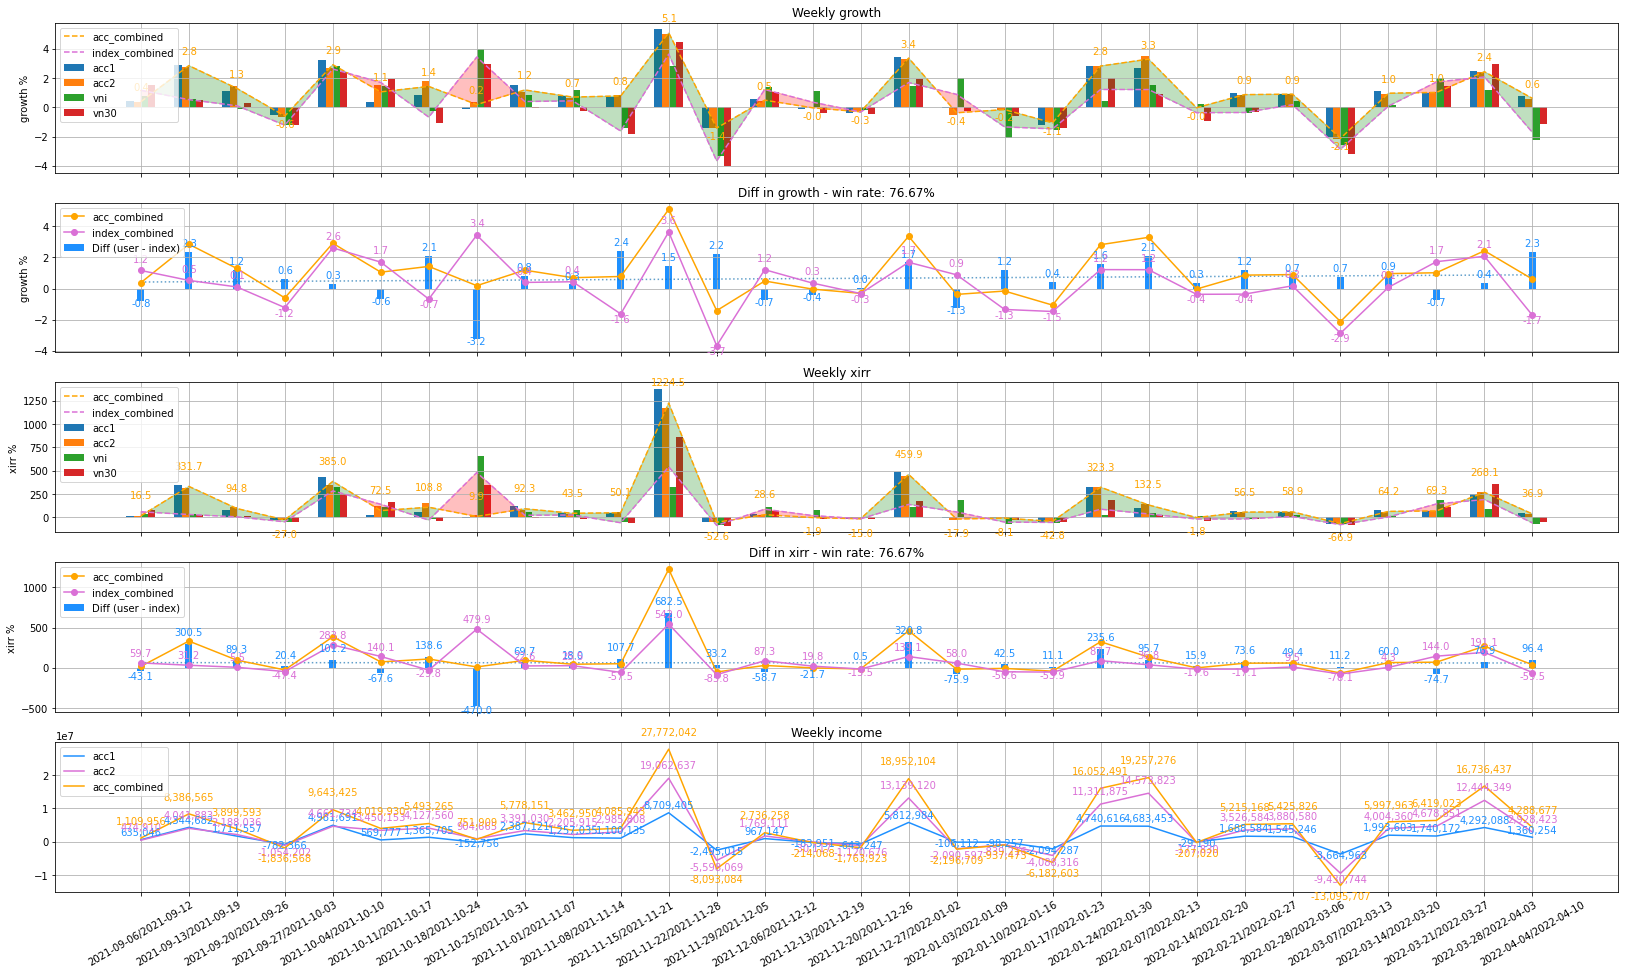

In [37]:
plot_growth_xirr(weekly_df, "Weekly")

In [38]:
weekly_df.tail()

,acc1_growth,acc2_growth,acc_combined_growth,vni_growth,vn30_growth,index_combined_growth,acc1_xirr,acc1_income,acc2_xirr,acc2_income,acc_combined_xirr,acc_combined_income,vni_xirr,vn30_xirr,index_combined_xirr
period,,,,,,,,,,,,,,,
2022-03-07/2022-03-13,-2.058541,-2.148521,-2.122120,-2.576844,-3.159951,-2.870322,-66.195760,-3664963.0,-67.207752,-9430744.0,-66.922031,-13095707.0,-74.366110,-81.255760,-78.097465
2022-03-14/2022-03-20,1.143592,0.885066,0.956953,0.174561,-0.013540,0.080172,80.913081,1993603.0,58.237188,4004360.0,64.243453,5997963.0,9.520493,-0.703559,4.267247
2022-03-21/2022-03-27,0.987132,1.024940,1.014405,2.001225,1.450296,1.725027,66.895072,1740172.0,70.205681,4678851.0,69.276815,6419023.0,181.002087,111.868244,143.953775
2022-03-28/2022-04-03,2.498198,2.404446,2.425999,1.197197,2.943885,2.070500,254.098316,4292088.0,273.209152,12444349.0,268.058414,16736437.0,85.994258,353.971888,191.128122
2022-04-04/2022-04-10,0.769564,0.548980,0.603881,-2.271109,-1.177332,-1.719567,49.143172,1360254.0,33.038856,2928423.0,36.879900,4288677.0,-69.816524,-46.072908,-59.522741


## [Chart] Monthly


In [39]:
monthly_df = get_period_df("M", log_df)
# Insufficient data for 2020-12
monthly_df.drop(["2020-12"], inplace=True)


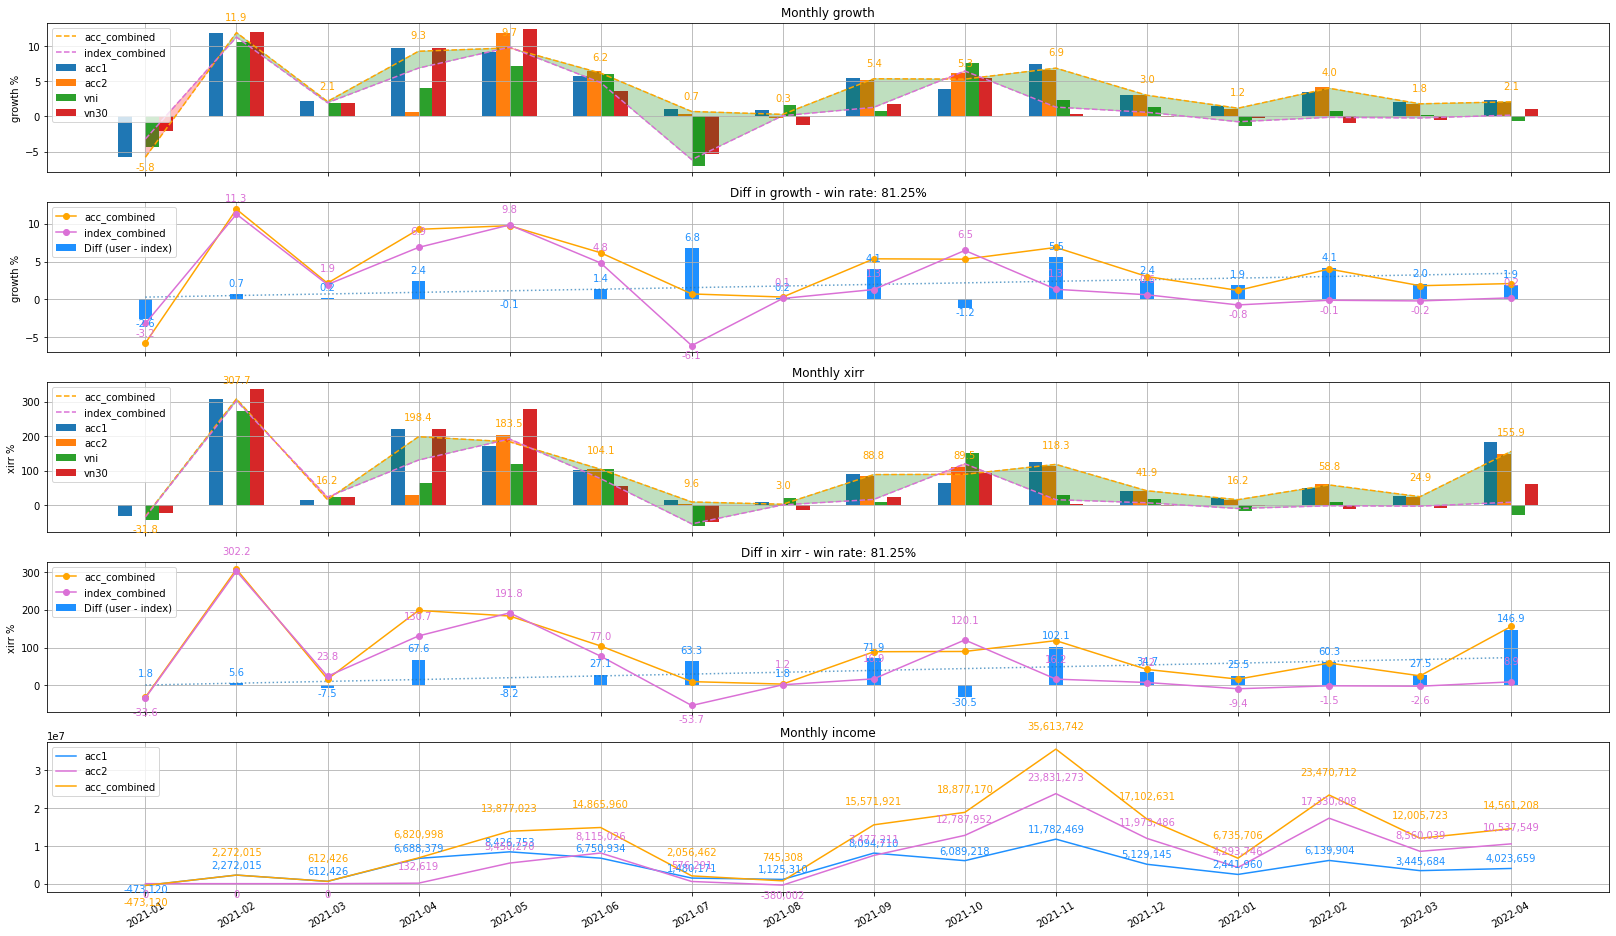

In [40]:
plot_growth_xirr(monthly_df, "Monthly")


In [41]:
monthly_df

,acc1_growth,acc2_growth,acc_combined_growth,vni_growth,vn30_growth,index_combined_growth,acc1_xirr,acc1_income,acc2_xirr,acc2_income,acc_combined_xirr,acc_combined_income,vni_xirr,vn30_xirr,index_combined_xirr
period,,,,,,,,,,,,,,,
2021-01,-5.801495,0.000000,-5.801495,-4.281301,-2.097556,-3.206048,-31.824347,-473120.0,0.000000,0.0,-31.824347,-473120.0,-42.347039,-23.418211,-33.643602
2021-02,11.919800,0.000000,11.919800,10.586688,11.951617,11.266461,307.719272,2272015.0,0.000000,0.0,307.719272,2272015.0,271.276845,335.658231,302.153138
2021-03,2.130464,0.000000,2.130464,1.965819,1.929107,1.947423,16.237842,612426.0,0.000000,0.0,16.237842,612426.0,24.026106,23.533099,23.778840
2021-04,9.782790,0.567937,9.265127,4.024542,9.700395,6.868173,221.794495,6688379.0,29.034322,132619.0,198.363712,6820998.0,64.314113,220.677577,130.723459
2021-05,9.143898,11.870611,9.742956,7.153519,12.383028,9.842966,172.713866,8426753.0,203.195840,5450270.0,183.538912,13877023.0,119.918082,278.708624,191.781984
2021-06,5.797309,6.513758,6.157616,6.061519,3.676481,4.806571,102.328338,6750934.0,105.643285,8115026.0,104.112592,14865960.0,104.622667,55.158770,77.035437
2021-07,1.017875,0.402725,0.706302,-6.993007,-5.347940,-6.136747,14.870849,1480171.0,5.011513,576291.0,9.587606,2056462.0,-58.605767,-48.763137,-53.723216
2021-08,0.864777,-0.264489,0.295285,1.635052,-1.283141,0.103363,9.396137,1125310.0,-2.975650,-380002.0,3.012620,745308.0,20.320626,-13.696960,1.185342
2021-09,5.494308,5.218083,5.357257,0.795362,1.756891,1.293055,91.896611,8094710.0,85.680531,7477211.0,88.805787,15571921.0,10.118424,23.602312,16.919240


## Quaterly


In [42]:
quaterly_df = get_period_df("Q", log_df)
quaterly_df.drop(["2020Q4"], inplace=True)


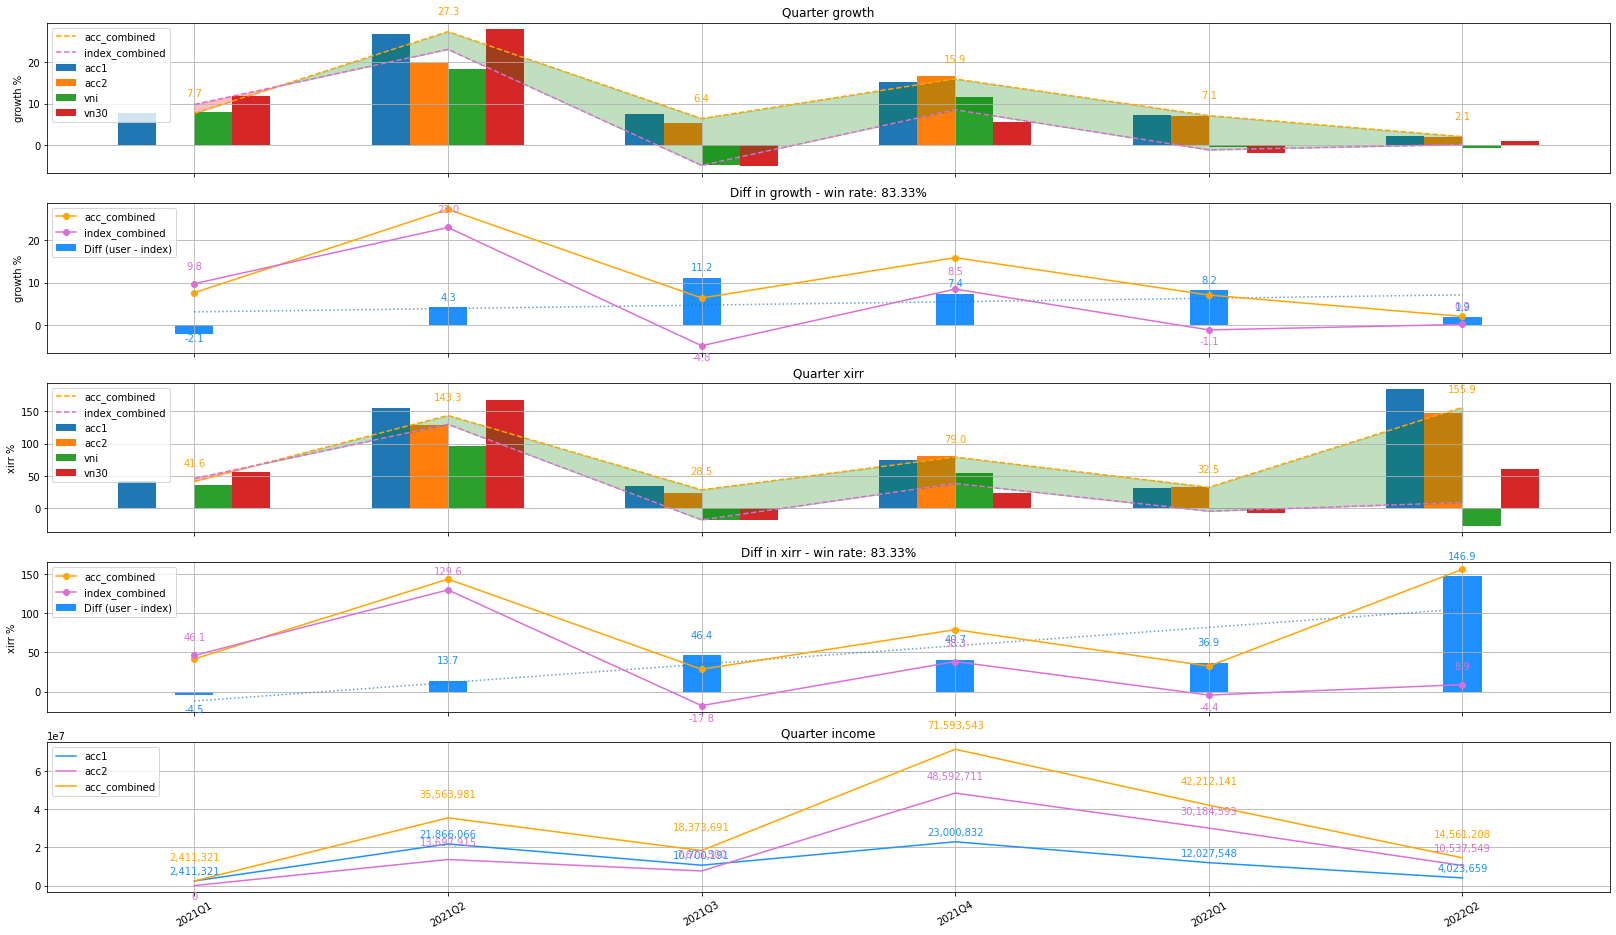

In [43]:
plot_growth_xirr(quaterly_df, "Quarter")


In [44]:
quaterly_df

,acc1_growth,acc2_growth,acc_combined_growth,vni_growth,vn30_growth,index_combined_growth,acc1_xirr,acc1_income,acc2_xirr,acc2_income,acc_combined_xirr,acc_combined_income,vni_xirr,vn30_xirr,index_combined_xirr
period,,,,,,,,,,,,,,,
2021Q1,7.672858,0.000000,7.672858,7.932999,11.717736,9.796564,41.598018,2411321.0,0.000000,0.0,41.598018,2411321.0,36.288398,56.733544,46.086448
2021Q2,26.767623,19.834332,27.294426,18.222487,27.817160,23.029468,154.510835,21866066.0,127.891901,13697915.0,143.347875,35563981.0,95.703804,167.625795,129.628450
2021Q3,7.489684,5.362412,6.414699,-4.720457,-4.920863,-4.824769,34.455969,10700191.0,23.027746,7673500.0,28.543260,18373691.0,-17.456391,-18.143055,-17.814336
2021Q4,15.080954,16.638849,15.924224,11.640314,5.637107,8.518789,74.305147,23000832.0,81.492486,48592711.0,79.025576,71593543.0,54.783555,24.305219,38.312675
2022Q1,7.157732,7.106849,7.117116,-0.409136,-1.769865,-1.097894,31.849295,12027548.0,32.800446,30184593.0,32.523571,42212141.0,-1.648930,-6.986046,-4.378446
2022Q2,2.311212,2.004020,2.080429,-0.680227,1.046051,0.187624,183.626856,4023659.0,147.265625,10537549.0,155.859191,14561208.0,-26.758919,60.766377,8.928695


## Yearly

In [45]:
yearly_df = get_period_df("Y", log_df)
yearly_df.drop(["2020"], inplace=True)

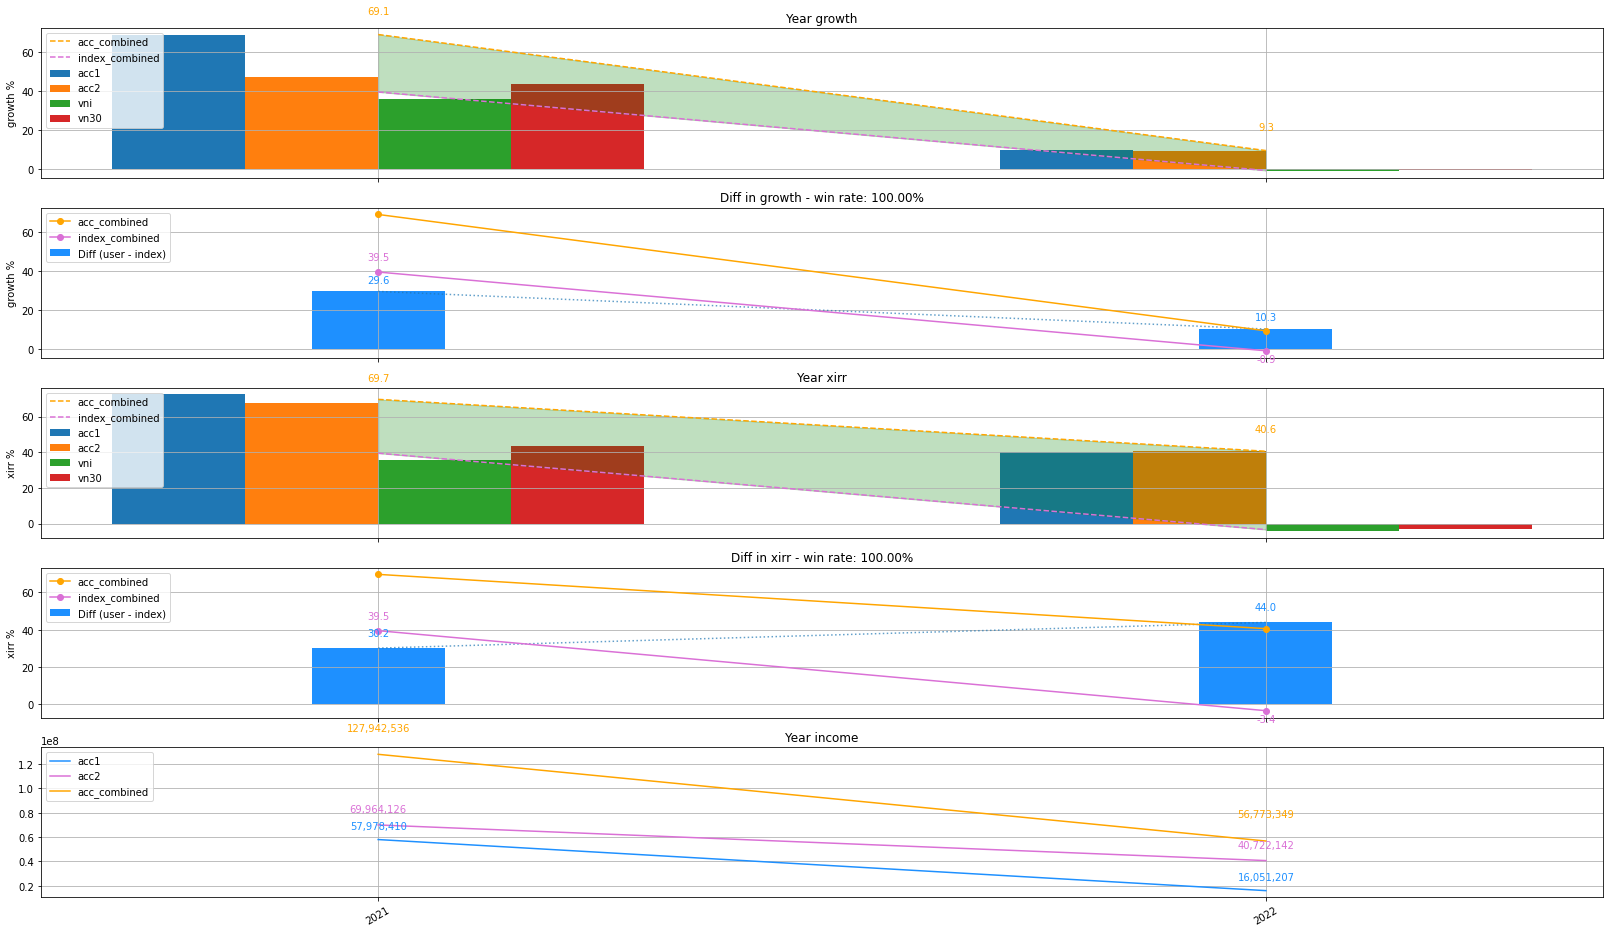

In [46]:
plot_growth_xirr(yearly_df, "Year")